# **Learning Dynamics using Neural Ordinary Differential Equations**



## Introduction

## Problem Statement

## Methods and Procedure

## Datasets and Visualization

In [170]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
from torchdiffeq import odeint_adjoint


### Generating Datasets

In [171]:
data_size = 1000 # time steps = 1000


true_x0s = [torch.tensor([[1., 1.]]).cuda(),
            torch.tensor([[0.5, 1.]]).cuda(),
            torch.tensor([[1., 0.5]]).cuda()]  # Choosing three initial conditions to train on three different trajectories

t = torch.linspace(0., 10., data_size).cuda() # time 


In [172]:
class LotkaVolterra(nn.Module):
    '''
    This is the true LotkaVolterra dynamical System. 
    x1dot = ax1 - bx1x2;
    x2dot = cx1x2 - dx2;
    Where, x1 is prey population, x2 is predator population
    '''
    def __init__(self, a, b, c, d):
        super().__init__()
        self.a = a
        self.b = b
        self.c = c
        self.d = d

    def forward(self, t, x):
        x1 = x[0, 0]
        x2 = x[0, 1]
        return torch.tensor([[self.a * x1 - self.b * x1 * x2,
                              self.c * x1 * x2 - self.d * x2]]).cuda()

true_xs = [] # This will contain x(t) for different x(0) conditions

for true_x0 in true_x0s:
    with torch.no_grad():
        true_x = odeint_adjoint(func=LotkaVolterra(a=1.5, b=1, c=1, d=0.5), y0 = true_x0, t = t)
        true_xs.append(true_x)



In [173]:
noisy_xs = []

for true_x in true_xs:
    # specify the standard deviation of the noise
    noise_stddev = 0.01
    # generate random noise tensor with the same shape as true_y
    noise = (torch.randn(true_x.shape) * noise_stddev).cuda()
    # add the noise to true_y
    noisy_x = true_x + noise
    noisy_xs.append(noisy_x)


### Visualizing datasets

In [174]:
def visualize(t, true_x, noisy_x=None, pred_x=None, loss = None, filename= None, show = True):
  
  fig = plt.figure(figsize=(12, 6), facecolor='white')
  ax = fig.add_subplot(121)

  ax.set_title('Phase Portrait')
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')
  
  ax2 = fig.add_subplot(122)
  ax2.set_title('Trajectories')
  ax2.set_xlabel('t')
  ax2.set_ylabel('$x_1$,$x_2$')


  t = t.cpu().numpy()

  true_x = true_x.cpu().numpy()
  true_x1 = true_x[:, 0, 0]
  true_x2 = true_x[:, 0, 1]
  ax.plot(true_x1, true_x2, 'blue')
  ax2.plot(t, true_x1,'b-', label = f'x_1')
  ax2.plot(t, true_x2, 'g-', label=f'x_2')
  
  ax2.legend()
    
  ax.plot([], [], 'blue', label='true trajectory')

  if noisy_x is not None:
    noisy_x = noisy_x.cpu().numpy()
    noisy_x1 = noisy_x[:, 0, 0]
    noisy_x2 = noisy_x[:, 0, 1]
    ax.scatter(noisy_x1, noisy_x2, color='blue', s=1)
    ax.scatter([], [], color='blue', label='sampled data', s=1)

  if pred_x is not None:
    pred_x = pred_x.cpu().numpy()
    pred_x1 = pred_x[:, 0, 0]
    pred_x2 = pred_x[:, 0, 1]
  
    ax.plot(pred_x1, pred_x2, 'red')
    ax2.plot(t, pred_x1,'b--', label=f'x_1 (predicted)')
    ax2.plot(t, pred_x2, 'g--', label=f'x_2 (predicted)')
    ax2.legend()

    ax.plot([], [], 'red', label='Predicted trajectory')
 


  ax.set_xlim(true_x1.min() * 0.8, true_x1.max() * 1.2)
  ax.set_ylim(true_x2.min() * 0.8, true_x2.max() * 1.2)

  ax2.set_xlim(t.min(), t.max())
  ax2.set_ylim(true_x.min() * 0.8, true_x.max() * 1.2)
  ax.legend()
  ax2.grid(True)
  if show:
    plt.show()
  if filename is not None:
    fig.savefig(f'./images/{filename}.png')
    plt.close(fig)


initial condition 1


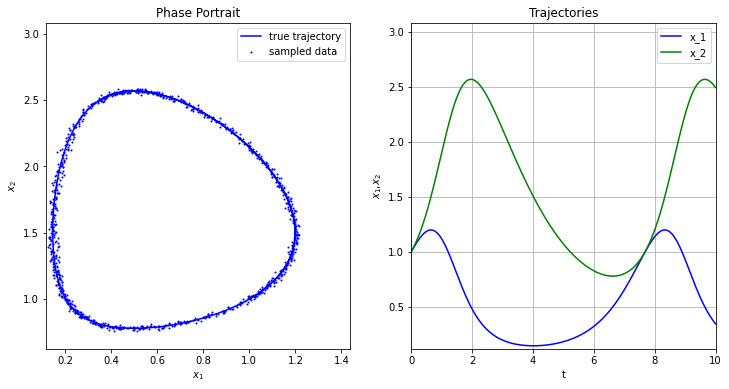

initial condition 2


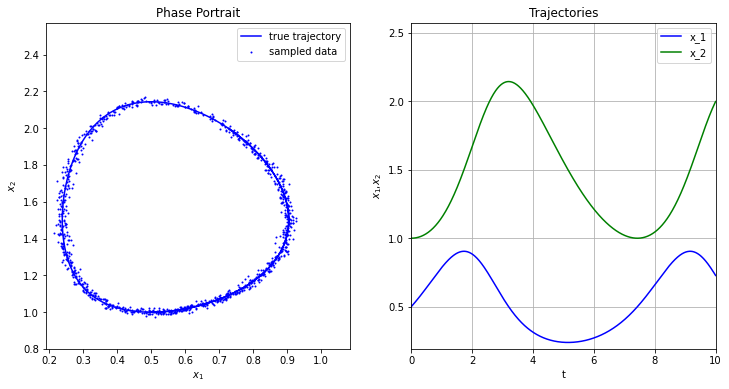

initial condition 3


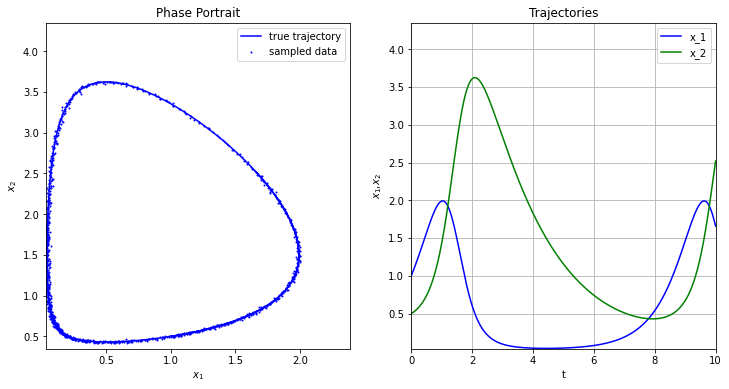

In [175]:
%matplotlib inline
for i, (true_x, noisy_x) in enumerate(zip(true_xs, noisy_xs)):
  print(f'initial condition {i+1}')
  visualize(t, true_x, noisy_x)


## Training

In [176]:
class PredictedLotkaVolterra(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(2, 32),
                             nn.SiLU(),
                             nn.Linear(32, 32),
                             nn.SiLU(),
                             nn.Linear(32, 2))
  def forward(self, t, y):
    output = self.net(y)
    return output


In [177]:
batch_time = 20
batch_size = 32


def get_batch():
    batch_xs =[]
    batch_x0s = []
    batch_ts = []
    for noisy_x in noisy_xs:
        
        s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
        batch_x0 = noisy_x[s]  # (batch_size, 1, emb)
        batch_t = t[:batch_time]  # (T)
        # (time, batch_size, 1, emb)
        batch_x = torch.stack([noisy_x[s + i] for i in range(batch_time)], dim=0)
        batch_xs.append(batch_x.cuda())
        batch_x0s.append(batch_x0.cuda())
        batch_ts.append(batch_t.cuda())

    return batch_x0s, batch_ts, batch_xs  


In [178]:
# batch_x0s, batch_ts, batch_xs =get_batch()

In [179]:
%matplotlib agg

# Train
niters = 400

func = PredictedLotkaVolterra().cuda()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()
loss_history = []
time_history = []
for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_x0s, batch_ts, batch_xs = get_batch()
  for batch_x0, batch_t, batch_x in zip(batch_x0s, batch_ts, batch_xs):
    pred_x = odeint_adjoint(func=func, y0=batch_x0, t=batch_t,
                          rtol=1e-7, atol=1e-9, method='dopri5')
    loss = torch.mean(torch.abs(pred_x - batch_x))
    loss.backward()
    optimizer.step()


  if iter % 10 == 0:
    pred_xs=[]
    for i, (true_x0, noisy_x, true_x) in enumerate(zip(true_x0s, noisy_xs, true_xs)) :
      with torch.no_grad():
        pred_x = odeint_adjoint(func, true_x0, t, rtol=1e-7,
                              atol=1e-9, method='dopri5')
        loss = torch.mean(torch.abs(pred_x - noisy_x))
        # print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
        timecomp = time.time() - start_time
        time_history.append(timecomp)
        loss_history.append(loss.item())
        visualize(t, true_x, noisy_x, pred_x,
                  filename=f'iter_{iter:04d}_ic{i}', show=False)

end_time = time.time() - start_time
print('process time: {} sec'.format(end_time))


  0%|          | 0/401 [00:00<?, ?it/s]

process time: 281.3881537914276 sec


In [180]:
torch.save(func.state_dict(), 'model.pth')


### Results of Training

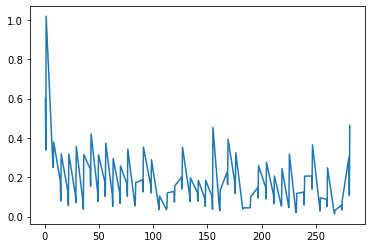

In [181]:
# Learning curve
%matplotlib inline
plt.plot(time_history, loss_history)
plt.savefig('Learning_curve.png')


In [182]:
# Making gifs

import os
from PIL import Image, ImageDraw, ImageFont

import glob

for ic in range(3):
    frames = []
    imgs = sorted(glob.glob(f"images/iter_*_ic{ic}.png"))
    for i in imgs:
        new_frame = Image.open(i)
        draw = ImageDraw.Draw(new_frame)
        filename = os.path.basename(i)

        font_size = 24
        font = ImageFont.truetype(
            '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', font_size)
        # Draw the text on the image
        name = filename.replace('.png', '')
        draw.text((30, 30), name, font=font, fill=(0, 0, 0))
        new_frame.save("images/"+filename, format='PNG')
        frames.append(new_frame)

    frames[0].save(f'ic{ic}.gif', format='GIF', append_images=frames[1:],
                   save_all=True,
                   duration=300,
                   loop=1)


## Testing

In [183]:
# Choosing 2x3 initial values from the training datasets 
s = torch.from_numpy(np.random.choice(np.arange(data_size), 2, replace=False))
test_x0s_inside = [] 

for noisy_x in noisy_xs:
    test_x0 = noisy_x[s]
    test_x0s_inside.append(test_x0)
test_x0s_inside = torch.cat(test_x0s_inside, dim=0)

In [184]:
import torch


def randbetween(lb, ub):
    # Create a tensor of shape (1, 2) with values between 0 and 1
    tensor_2d = torch.zeros(1, 2).uniform_(lb, ub)
    return tensor_2d.cuda()



test_x0s_outside = [randbetween(2,3) for _ in range(6)]
test_x0s_outside


[tensor([[2.2211, 2.8607]], device='cuda:0'),
 tensor([[2.6982, 2.1310]], device='cuda:0'),
 tensor([[2.9194, 2.6310]], device='cuda:0'),
 tensor([[2.4083, 2.2010]], device='cuda:0'),
 tensor([[2.9979, 2.9257]], device='cuda:0'),
 tensor([[2.9129, 2.2810]], device='cuda:0')]

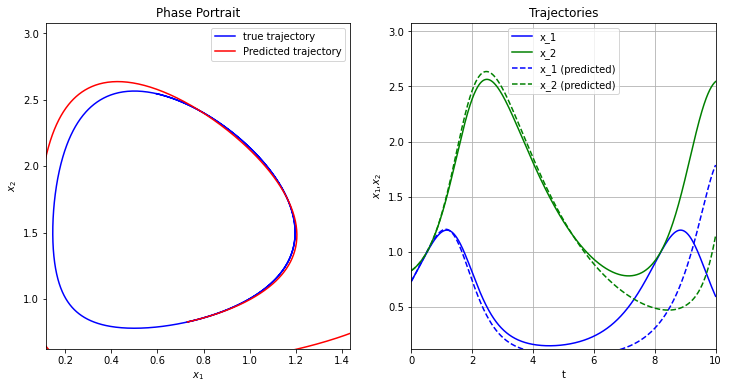

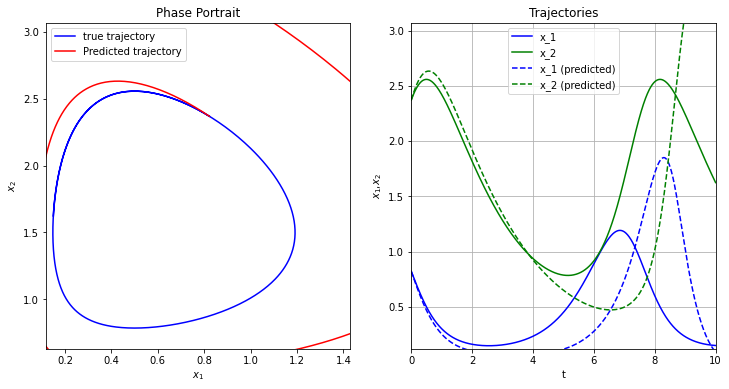

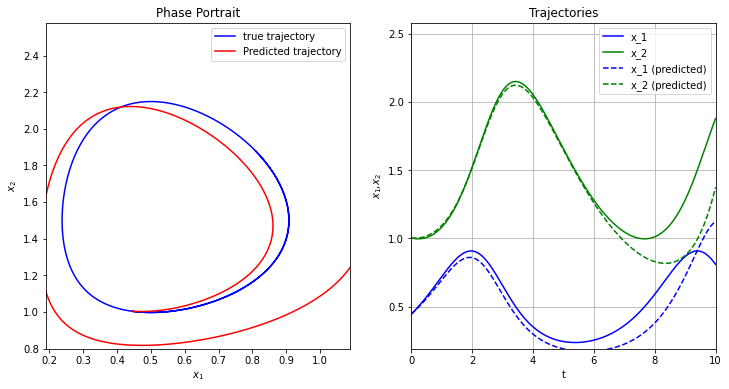

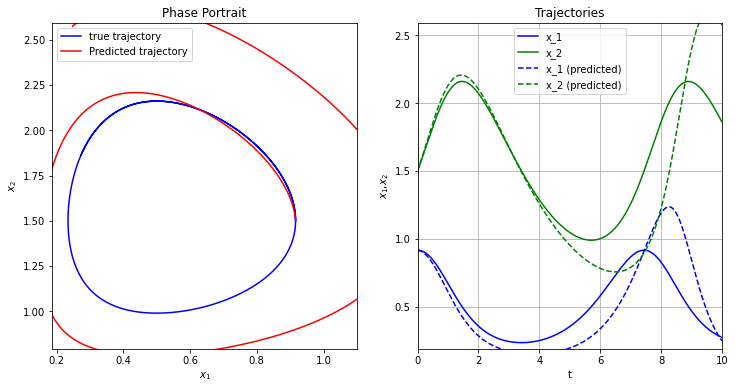

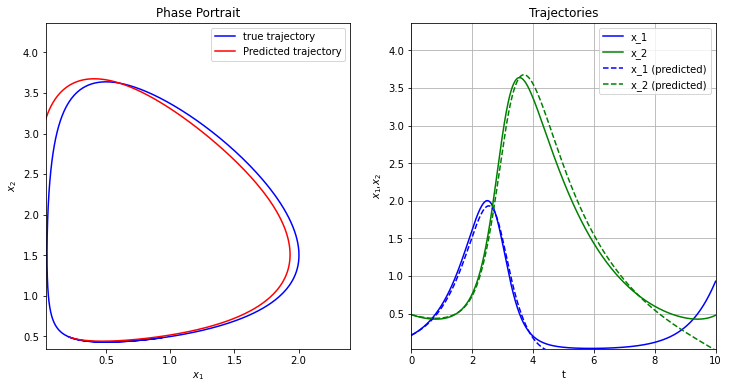

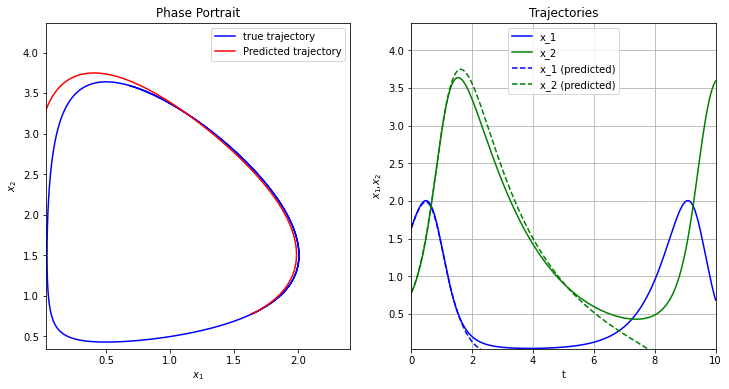

In [185]:
%matplotlib inline
for test_x0 in test_x0s_inside:
    with torch.no_grad():
        true_x = odeint_adjoint(LotkaVolterra(a=1.5, b=1, c=1, d=0.5), y0 = test_x0, t=t, rtol=1e-7, atol = 1e-9, method='dopri5')
        test_x = odeint_adjoint(func, test_x0, t, rtol=1e-7,
                                atol=1e-9, method='dopri5')
        visualize(t= t, true_x = true_x, pred_x = test_x)


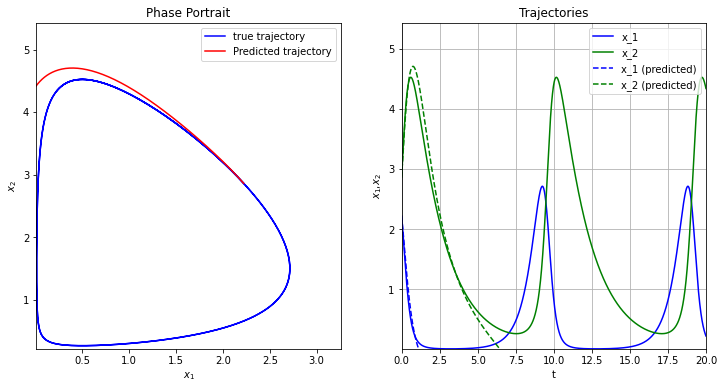

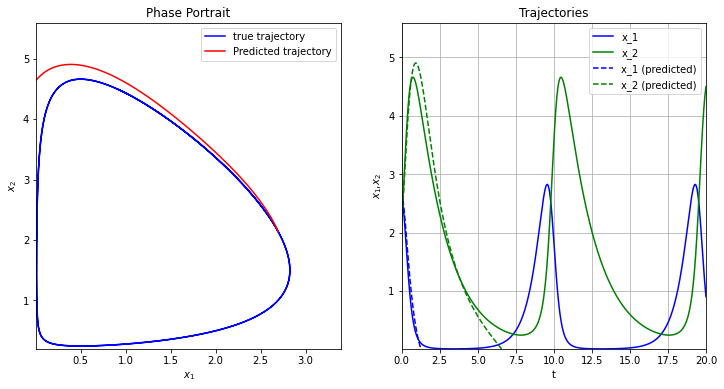

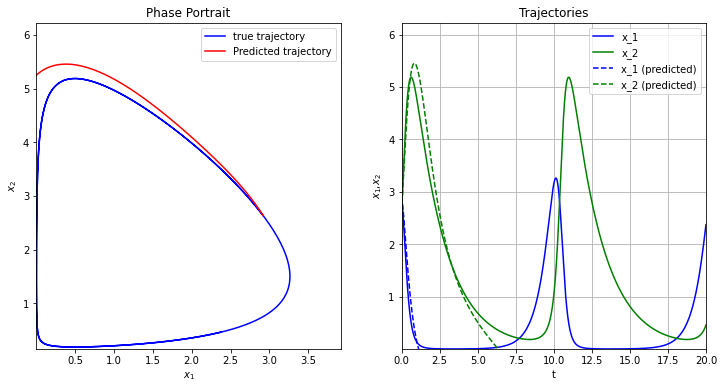

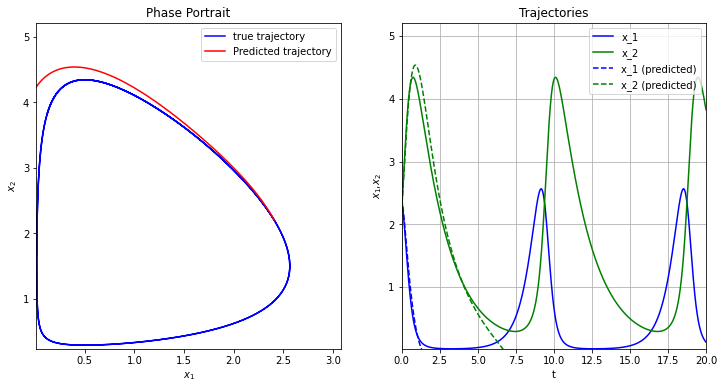

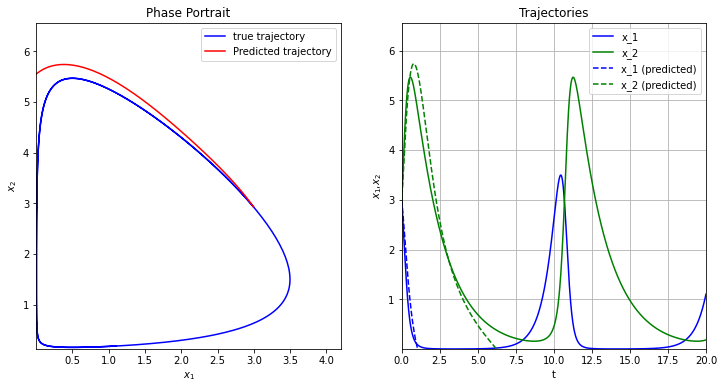

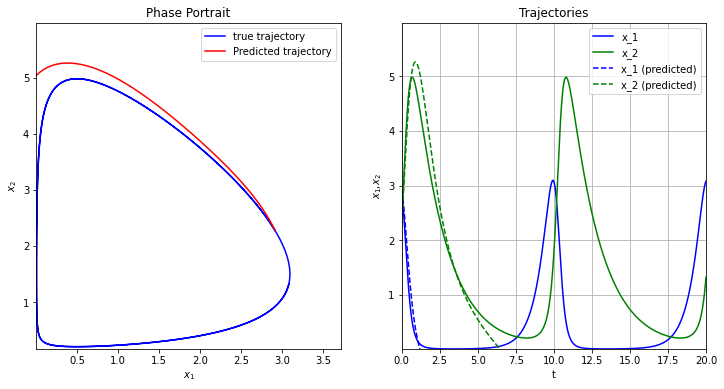

In [186]:
t = torch.linspace(0,20,2000).cuda()
for test_x0 in test_x0s_outside:
    with torch.no_grad():
        true_x = odeint_adjoint(LotkaVolterra(a=1.5, b=1, c=1, d=0.5), y0=test_x0, t=t, rtol=1e-7, atol=1e-9,
                                method='dopri5')
        test_x = odeint_adjoint(func, test_x0, t, rtol=1e-7,
                                atol=1e-9, method='dopri5')
        visualize(t=t, true_x=true_x, pred_x=test_x)


In [187]:
def remove_all(folder_path="./", ext=".png"):
    import os
    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file extension is .png
        if filename.endswith(ext):
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)
            # Delete the file
            os.remove(file_path)

# remove_all(folder_path="images/",ext=".png")

In [188]:
from IPython.display import HTML

# Create an HTML image tag that references the GIF file
gif0 = '<img src="ic0.gif">'
gif1 = '<img src="ic1.gif">'
gif2 = '<img src="ic2.gif">'
# Display the HTML tag in the notebook output area
HTML(gif0)




In [189]:
HTML(gif2)


In [190]:
HTML(gif1)
